In [ ]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm

### Preparing the data

We need to restrict the data respect to a minimum transaction date. In that way, we reduce the dimensionality of the problem and we get rid of transactions that are not important in terms of the time decaying popularity.

In [ ]:
transactions = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv', dtype={'article_id':str})
transactions.drop(['sales_channel_id', 'price'], inplace=True, axis=1)
transactions['bought'] = 1

In [ ]:
start_date = pd.to_datetime('2020-08-22')
# Filter transactions by date
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
transactions = transactions.loc[transactions["t_dat"] >= start_date]

# Filter transactions by number of articles each customer has been bought
customer_bought_count = transactions[['customer_id', 't_dat']].groupby('customer_id').count().reset_index().rename(columns={'t_dat': 'count'})
most_bought_customers = customer_bought_count[customer_bought_count['count']>3]['customer_id'].values
transactions = transactions[transactions['customer_id'].isin(most_bought_customers)]

# Filter transactions by number of an article has been bought in total.
article_bought_count = transactions[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})
most_bought_articles = article_bought_count[article_bought_count['count']>10]['article_id'].values
transactions = transactions[transactions['article_id'].isin(most_bought_articles)]

In [ ]:
''' Calculate time decaying popularity '''
# Calculate time decaying popularity. This leads to items bought more recently having more weight in the popularity list.
# In simple words, item A bought 5 times on the first day of the train period is inferior than item B bought 4 times on the last day of the train period.
transactions['pop_factor'] = transactions['t_dat'].apply(lambda x: 1/(datetime.datetime(2020,9,23) - x).days)
transactions_by_article = transactions[['article_id', 'pop_factor']].groupby('article_id').sum().reset_index()
default_recommendation = transactions_by_article.sort_values(by='pop_factor', ascending=False)['article_id'].values[:12]

In [ ]:
default_recommendation

In [ ]:
transactions = transactions.groupby(['customer_id','article_id'])['bought'].count().reset_index()

In [ ]:
transactions.head()

In [ ]:
print("The number of customer: ",transactions['customer_id'].nunique())
print("The number of article: ",transactions['article_id'].nunique())

Due to the big amount of items, we can not consider the whole matrix in order to train. Therefore, we need to generate some negative samples: transactions that have never occured.

In [ ]:
# Generate negative samples
np.random.seed(0)

negative_samples = pd.DataFrame({
    'customer_id': np.random.choice(transactions.customer_id.unique(), transactions.shape[0]),
    'article_id': np.random.choice(transactions.article_id.unique(), transactions.shape[0]),
    'bought': np.zeros(transactions.shape[0])
})

In [ ]:
negative_samples.head()

### Defining the model

Model will be based on recommendations computed through the time decaying popularity and Matrix factorization to decompose into two low-dimensional matrices. In return, using the dot product of these two matrices to predict how many times one customer would buy one article. 

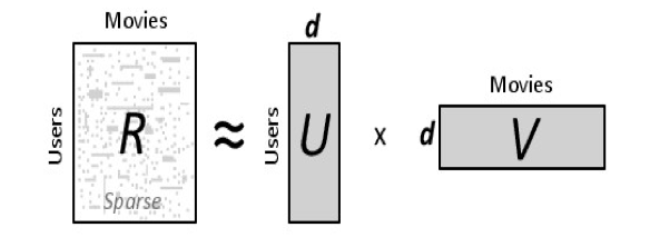

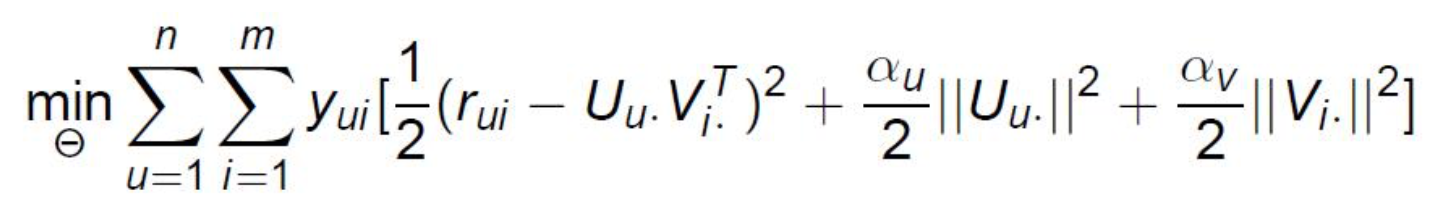
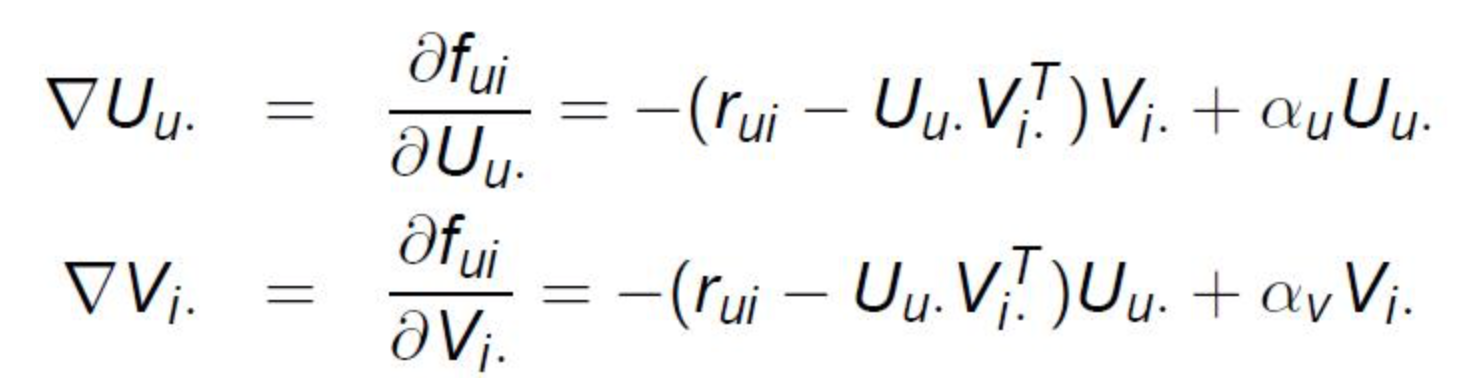

In [ ]:
class ItemBased_RecSys:
    ''' Collaborative filtering using a custom sim(u,u'). '''

    def __init__(self, positive_transactions, negative_transactions, num_components,default_recommendation):
        ''' Constructor '''
        self.positive_transactions = positive_transactions
        self.transactions = pd.concat([positive_transactions, negative_transactions])
        self.customers = self.transactions.customer_id.values
        self.articles = self.transactions.article_id.values
        self.bought = self.transactions.bought.values
        self.num_components = num_components
        self.default_recommendation = default_recommendation

        self.customer_id2index = {c: i for i, c in enumerate(np.unique(self.customers))}
        self.article_id2index = {a: i for i, a in enumerate(np.unique(self.articles))}
        ##Supplement
        self.id2index_customer = {i: c for i, c in enumerate(np.unique(self.customers))}
        self.id2index_article = {i: a for i, a in enumerate(np.unique(self.articles))}
        
    def __sdg__(self):
        """
        Based on transaction history, to train the latent matrix in order to fit real value. 
        """
        for idx in tqdm(self.training_indices):
            # Get the current sample
            customer_id = self.customers[idx]
            article_id = self.articles[idx]
            bought = self.bought[idx]

            # Get the index of the user and the article
            customer_index = self.customer_id2index[customer_id]
            article_index = self.article_id2index[article_id]

            # Compute the prediction and the error
            prediction = self.predict_single(customer_index, article_index)
            error = (bought - prediction) # error
            
            # Update latent factors in terms of the learning rate and the observed error
            self.customers_latent_matrix[customer_index] += self.learning_rate * \
                                    (error * self.articles_latent_matrix[article_index] - \
                                     self.lmbda * self.customers_latent_matrix[customer_index])
            self.articles_latent_matrix[article_index] += self.learning_rate * \
                                    (error * self.customers_latent_matrix[customer_index] - \
                                     self.lmbda * self.articles_latent_matrix[article_index])
                
                
    def fit(self, n_epochs=10, learning_rate=0.001, lmbda=0.1):
        ''' Compute the matrix factorization R = P x Q '''
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        n_samples = self.transactions.shape[0]
        
        # Initialize latent matrices
        self.customers_latent_matrix = np.random.normal(scale=1., size=(len(np.unique(self.customers)), self.num_components))
        self.articles_latent_matrix = np.random.normal(scale=1., size=(len(np.unique(self.articles)), self.num_components))
        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            self.training_indices = np.arange(n_samples)
            
            # Shuffle training samples and follow stochastic gradient descent
            np.random.shuffle(self.training_indices)
            self.__sdg__()
        

    def predict_single(self, customer_index, article_index):
        ''' Make a prediction for an specific user and article '''
        prediction = np.dot(self.customers_latent_matrix[customer_index], self.articles_latent_matrix[article_index])
        prediction = np.clip(prediction, 0, 100)
        
        return prediction


    def predict(self, customers):
        ''' Make recommendations '''
        recommendations = []
        
        # Make predictions
        for customer in tqdm(customers):
            if customer in self.customer_id2index:
                rec_aux1 = []
                rec_aux2 = []
                aux = []

                # Compute the target vector.
                similarity_matrix = np.dot(self.customers_latent_matrix[self.customer_id2index[customer]], np.transpose(self.articles_latent_matrix))

                # Convert similarity matrix into a matrix containing the 12 most similar items' index for each customer
                similarity_matrix = np.argsort(similarity_matrix)[::-1]
                similarity_matrix = similarity_matrix[:12]
                
                rec_aux1 = [self.id2index_article[i] for i in similarity_matrix]
                # Return the half of the default recommendation
                rec_aux2 = self.default_recommendation

                # Merge half of both recommendation lists
                for rec_idx in range(6):
                    aux.append(rec_aux2[rec_idx])
                    aux.append(rec_aux1[rec_idx])

                recommendations.append(' '.join(aux))
            else:
                # Return the default recommendation
                recommendations.append(' '.join(default_recommendation))
        
        return pd.DataFrame({
            'customer_id': customers,
            'prediction': recommendations,
        })

### Training

Define your hyperparameters and fit the model. Take into account that there are more customizable parameters in the data processing section.

In [ ]:
rec = ItemBased_RecSys(transactions, negative_samples,1000,default_recommendation)
rec.fit(n_epochs=20)

### Generating a submission

In [ ]:
customers = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv').customer_id.unique()

In [ ]:
recommendations = rec.predict(customers)

In [ ]:
recommendations.to_csv('submission.csv', index=False)